# Crane V2 model training and simulations

Adapted from https://github.com/kinwo/deeprl-navigation (MIT License Copyright (c) 2018 Henry Chan)

Start Environement and create DQN Agent

In [1]:
import gym
import numpy as np

env = gym.make('crane-v2') #Load the environement

## Agent

The DQN agent can be found below

In [2]:
import numpy as np
import random
from collections import namedtuple, deque

#from model import QNetwork # UNCOMMENT IF YOU ARE NOT IN A JUPYTER NOTEBOOK

import torch
import torch.nn.functional as F
import torch.optim as optim

BUFFER_SIZE = int(1e5)     # replay buffer size
BATCH_SIZE = 64            # minibatch size
GAMMA = 0.995 #was 0.99    # discount factor
TAU = 1e-3                 # for soft update of target parameters
LR =  5e-4                 # learning rate 
UPDATE_EVERY = 4           # how often to update the network

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Agent():
    """Interacts with and learns from the environment."""

    def __init__(self, state_size, action_size, seed):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            seed (int): random seed
        """

        
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)

        # Q-Network
        self.qnetwork_local = QNetwork(state_size, action_size, seed).to(device)
        self.qnetwork_target = QNetwork(state_size, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)       

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)
        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0
    
    def step(self, state, action, reward, next_state, done):
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)
        
        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > BATCH_SIZE:
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA)

    def act(self, state, eps=0.):
        """Returns actions for given state as per current policy.
        
        Params
        ======
            state (array_like): current state
            eps (float): epsilon, for epsilon-greedy action selection
        """
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        # Epsilon-greedy action selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences, gamma):
        """Update value parameters using given batch of experience tuples.

        Params
        ======
            experiences (Tuple[torch.Variable]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences

        # Get max predicted Q values (for next states) from target model
        Q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        # Compute Q targets for current states 
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))

        # Get expected Q values from local model
        Q_expected = self.qnetwork_local(states).gather(1, actions)

        # Compute loss
        loss = F.mse_loss(Q_expected, Q_targets)
        
        # Minimize the loss
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # ------------------- update target network ------------------- #
        self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU)                     

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)


class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.

        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
  
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

## Deep Q_Network Model

A 2 linear hidden layer of 64 nodes each is created, with relu activation function. 

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class QNetwork(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed, fc1_units=64, fc2_units=64): 
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)
        


    def forward(self, state):
        """Build a network that maps state -> action values."""
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

## DQN Agent Training

### Create DQN Agen

In [4]:
import torch
import time
from collections import deque
#from agent import Agent   # UNCOMMENT IF YOU ARE NOT IN A JUPYTER NOTEBOOK
import matplotlib.pyplot as plt
%matplotlib inline

state_size=7        #State size of  environement 
action_size=11       #Action size of enviroenemnt
seed=0
agent = Agent(state_size=7, action_size=11, seed=0) #setting the agent's parameters 

Here, we save the model every 100 timesteps, in order to observe how the agent performs over it's training process. 
The files are located in the working derictory inder the name 'Episode_###.path'. 

In order to know when the environement is solved, we compute the moving score (the total rewards per episode) average over the last 100 episodes. If the moving average is over a chosen thershold (target_scores), the model is then saved to 'model_weight_name'. 

For the Crane_v0 environement, the target score is 10 000 000, since it is the reward obtained by the agent when finding the flag. 

In [5]:
model_weight_name = 'model.pth'

def dqn(n_episodes=1300, max_t=1500, eps_start=1.0, eps_end=0.01, eps_decay=0.996, target_scores=200000.0):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
        target_scores (float): average scores aming to achieve, the agent will stop training once it reaches this scores
    """
    start = time.time()                # Start time
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    
    for i_episode in range(1, n_episodes+1):
        # Reset env and score at the beginning of episode
        env_info = env.reset()                             # reset the environment
        state = env.state                                  # get the current state
        score = 0                                          # initialize the score
        
        arr_x = []                                         
        arr_x_dot = []
        arr_theta1 = []
        arr_theta1_dot = []
        arr_theta2 = []
        arr_theta2_dot = []
        arr_t = []
        
        for t in range(max_t):
            action = agent.act(state, eps)
            env_info = env.step(action)                    # send the action to the environment
            next_state = env_info[0]                       # get the next state
            reward = env_info[1]                           # get the reward
            done = env_info[2]                             # see if episode has finished
            
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            
            arr_t.append(t)
            arr_x.append(state[0])
            arr_x_dot.append(state[1])
            arr_theta1.append(state[2])
            arr_theta1_dot.append(state[3])
            arr_theta2.append(state[4])
            arr_theta2_dot.append(state[5])
            if score > 100000:
                tarr_x = arr_x                                      
                tarr_x_dot = arr_x_dot
                tarr_theta1 = arr_theta1
                tarr_theta1_dot = arr_theta1_dot
                tarr_theta2 = arr_theta2
                tarr_theta2_dot = arr_theta2_dot
                tarr_t = arr_t
                temp_model_weight_name = 'Episode_score{}.pth'.format(score) 
                torch.save(agent.qnetwork_local.state_dict(), temp_model_weight_name)
                
            if done:
                print("\n Episode finished after {} timesteps".format(t+1))
                print("\n final state is :", state)
                print("\n Reward is : ", score)
                break 

        scores_window.append(score)       # saving the most recent score
        scores.append(score)              # saving the most recent score
        eps = max(eps_end, eps_decay*eps) # decrease of the epsilon value
        
        
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
            temp_model_weight_name = 'Episode_{}.pth'.format(i_episode) 
            torch.save(agent.qnetwork_local.state_dict(), temp_model_weight_name)
        
        if np.mean(scores_window)>=target_scores:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), model_weight_name)
            break

    time_elapsed = time.time() - start
    print("Time Elapse: {:.2f}".format(time_elapsed))
    
    return scores

scores = dqn(n_episodes=3000, max_t=1500, eps_start=1.0, eps_end=0.01, eps_decay=0.997, target_scores=100000.0)




Episode 100	Average Score: -10042.78
Episode 200	Average Score: -9947.411
Episode 300	Average Score: -10042.79
Episode 400	Average Score: -9914.199
Episode 500	Average Score: -9937.186
Episode 600	Average Score: -9813.782
Episode 700	Average Score: -9769.14
Episode 800	Average Score: -9987.472
Episode 900	Average Score: -9973.65
Episode 1000	Average Score: -9878.62
Episode 1100	Average Score: -9742.19
Episode 1200	Average Score: -9569.14
Episode 1300	Average Score: -10109.39
Episode 1400	Average Score: -9832.775
Episode 1500	Average Score: -9741.588
Episode 1600	Average Score: -9813.78
Episode 1700	Average Score: -9906.16
Episode 1800	Average Score: -9395.68
Episode 1900	Average Score: -9537.58
Episode 2000	Average Score: -9689.27
Episode 2100	Average Score: -8842.66
Episode 2200	Average Score: -9792.707
Episode 2300	Average Score: -9696.70
Episode 2400	Average Score: -9434.11
Episode 2500	Average Score: -9830.64
Episode 2600	Average Score: -8967.83
Episode 2700	Average Score: -9466.92

### Score plot for each episodes

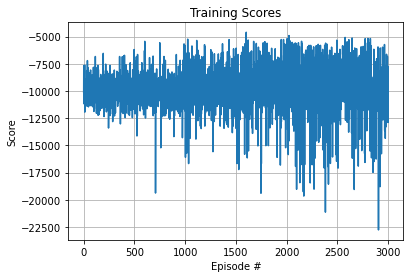

In [6]:
# plot the scores


fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.title('Training Scores')
plt.grid()
plt.savefig('plots/model_training.png', dpi = 200)
plt.show()

Since the environement is not solved, we choose the best model from where the score plot converges before diverging. After trial and error, it is found to be arround episode 600. We renamed the model "Episode_600.pth' to 'model.pth' and visualised it in the next block. 

In order to plot the state against time, we save the data points in local arrays.  


In [7]:
#Choose model
agent.qnetwork_local.state_dict() 

#agent.qnetwork_local.load_state_dict(torch.load('model.pth'))

env_info = env.reset()                             # reset the environment
state = env.state                                  # get the current state
score = 0                                          # initialize the score

#Initialising the state arrays
arr_x = []                                         
arr_x_dot = []
arr_theta1 = []
arr_theta1_dot = []
arr_theta2 = []
arr_theta2_dot = []
arr_t = []


t = 0
max_t = 1000                                       # Number of timesteps
for t in range(max_t) :
    #env.render()
    #time.sleep(0.008)
    action = agent.act(state)                      # select an action
    env_info = env.step(action)                    # send the action to the environment
    next_state = env_info[0]                       # get the next state
    reward = env_info[1]                           # get the reward
    done = env_info[2]                             # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    t += 1.0
    
    #Saving states in state matrix for the plot
    arr_t.append(t)
    arr_x.append(state[0])
    arr_x_dot.append(state[1])
    arr_theta1.append(state[2])
    arr_theta1_dot.append(state[3])
    arr_theta2.append(state[4])
    arr_theta2_dot.append(state[5])
    


    
    if done:                                       # exit loop if episode finished
        print("Total steps : ", t)
        print("Total time is : ", env.tau * t)
        break
        
arr_t = 0.02*np.array(arr_t)                       # Switching time steps for times in seconds
print("Score: {}".format(score))
env.close()


Score: -7468.544648733661


### States against time plots

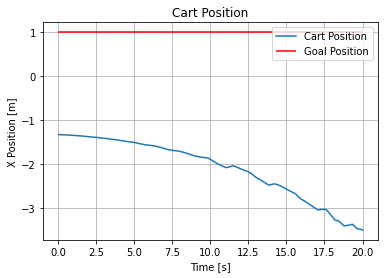

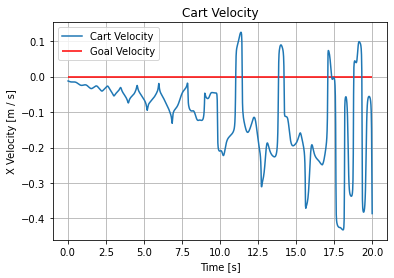

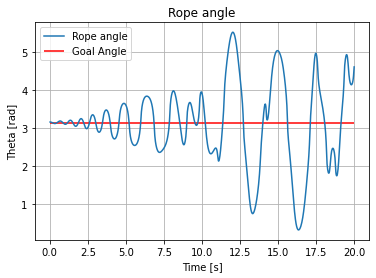

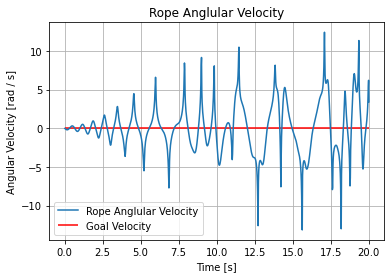

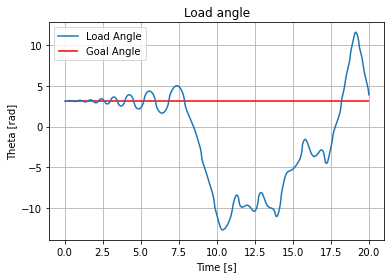

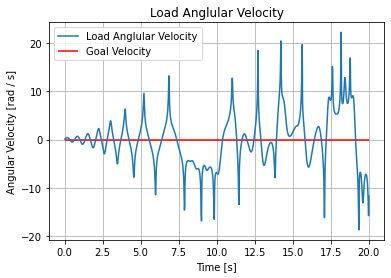

In [8]:
import math

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(arr_t, arr_x, label='Cart Position')
plt.ylabel('X Position [m]')
plt.xlabel('Time [s]')
plt.title('Cart Position')
plt.hlines(1.0, 0, arr_t[-1], colors='r', linestyles='solid', label='Goal Position')
plt.legend()
plt.grid()
plt.savefig('plots/model_x.png', dpi = 200)  #UNCOMMENT TO SAVE PLOT
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(arr_t, arr_x_dot, label = 'Cart Velocity')
plt.ylabel('X Velocity [m / s]')
plt.xlabel('Time [s]')
plt.title('Cart Velocity')
plt.hlines(0.0, 0, arr_t[-1], colors='r', linestyles='solid', label='Goal Velocity')
plt.legend()
plt.grid()
plt.savefig('plots/model_x_dot.png', dpi = 200)   #UNCOMMENT TO SAVE PLOT
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(arr_t, arr_theta1, label = 'Rope angle')
plt.ylabel('Theta [rad]')
plt.xlabel('Time [s]')
plt.title('Rope angle')
plt.hlines(math.pi, 0, arr_t[-1], colors='r', linestyles='solid', label='Goal Angle')
plt.legend()
plt.grid()
plt.savefig('plots/model_theta1.png', dpi = 200)   #UNCOMMENT TO SAVE PLOT
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(arr_t, arr_theta1_dot, label = 'Rope Anglular Velocity')
plt.ylabel('Angular Velocity [rad / s]')
plt.xlabel('Time [s]')
plt.title('Rope Anglular Velocity')
plt.hlines(0.0, 0, arr_t[-1], colors='r', linestyles='solid', label='Goal Velocity')
plt.legend()
plt.grid()
plt.savefig('plots/model_theta1_dot.png', dpi = 200)   #UNCOMMENT TO SAVE PLOT
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(arr_t, arr_theta2, label = 'Load Angle')
plt.ylabel('Theta [rad]')
plt.xlabel('Time [s]')
plt.title('Load angle')
plt.hlines(math.pi, 0, arr_t[-1], colors='r', linestyles='solid', label='Goal Angle')
plt.legend()
plt.grid()
plt.savefig('plots/model_theta2.png', dpi = 200)   #UNCOMMENT TO SAVE PLOT
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(arr_t, arr_theta2_dot, label = 'Load Anglular Velocity')
plt.ylabel('Angular Velocity [rad / s]')
plt.xlabel('Time [s]')
plt.title('Load Anglular Velocity')
plt.hlines(0.0, 0, arr_t[-1], colors='r', linestyles='solid', label='Goal Velocity')
plt.legend()
plt.grid()
plt.savefig('plots/model_theta2_dot.png', dpi = 200)   #UNCOMMENT TO SAVE PLOT
plt.show()
